In [1]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler 

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

from tensorflow import keras
from sklearn.preprocessing import StandardScaler 
import plotly.graph_objects as go

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 
import seaborn as sns #visualisation
 

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV  

In [3]:
# import data set from the local driver 
df=pd.read_csv('SWaT_Dataset_Attack_v0 - Copy.csv')#, parse_dates = ['Timestamp'], index_col = 'Timestamp')
df.head(2)   

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,1,1,2,1,2,1,19.74838,2.206835,956.1651,1,2,1,1,1,2,148.808,156.0882,1.713517,942.0662,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723789,1.279621,0.735269,0.307786,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,1,1,2,1,2,1,19.74838,2.208244,956.1651,1,2,1,1,1,2,148.808,156.0882,1.715952,942.0277,1,2,1,1,2,7.878621,145.1166,264.5475,12.03538,1.723789,1.297554,0.735269,0.307786,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal


In [4]:
# drop the Acutotor colomuns 
df1=df.drop(['Timestamp',' MV101','P101','P102', ' MV201', ' P201', ' P202','P203', ' P204','P205','P206','MV301','MV302',' MV303','MV304','P301','P302','P401','P402','P403','P404','UV401','P501','P502','P601','P602','P603'],axis=1)#, inplace=True) 

In [5]:
#If there are missing entries, drop them.
df1.dropna(inplace=True)#,axis=1)  

In [6]:
# Rows containing duplicate data
duplicate_rows_df = df1[df1.duplicated()]
print("number of duplicate rows:", duplicate_rows_df.shape) 

number of duplicate rows: (8121, 26)


In [7]:
# Dropping the duplicates 
df1= df1.drop_duplicates()
df1.head(2)   

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,AIT402,FIT401,LIT401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,Normal/Attack
0,2.427057,522.8467,262.0161,8.396437,328.6337,2.445391,19.74838,2.206835,956.1651,148.808,156.0882,1.713517,942.0662,7.878621,145.1166,264.5475,12.03538,1.723789,1.279621,0.735269,0.307786,250.8652,1.649953,189.5988,0.000128,Normal
1,2.446274,522.8860,262.0161,8.396437,328.6337,2.445391,19.74838,2.208244,956.1651,148.808,156.0882,1.715952,942.0277,7.878621,145.1166,264.5475,12.03538,1.723789,1.297554,0.735269,0.307786,250.8652,1.649953,189.6789,0.000128,Normal


In [8]:
# Counting the number of rows after removing duplicates.
df1.shape 

(441798, 26)

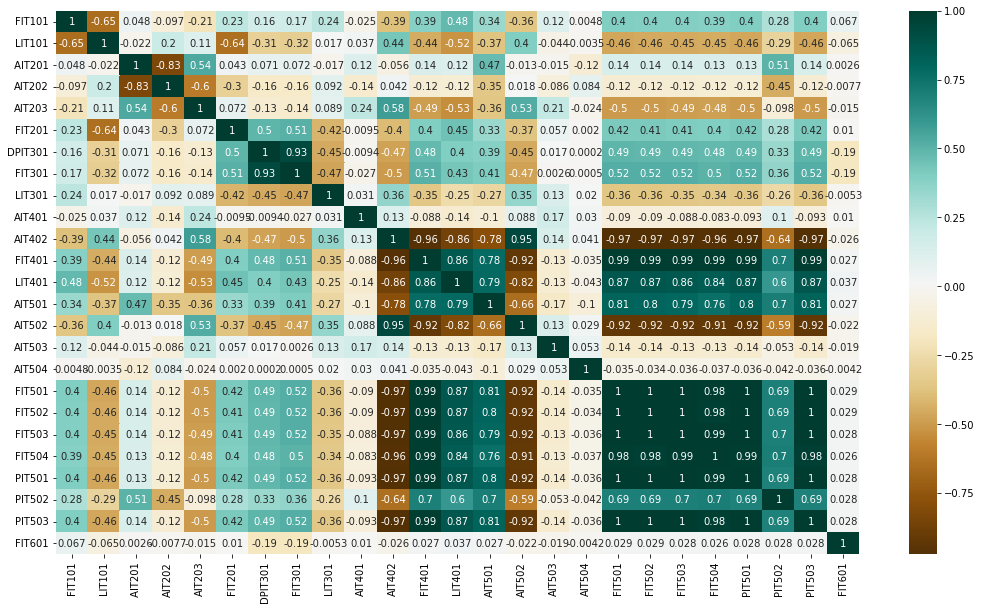

In [9]:
# Finding the relations between the variables.
plt.figure(figsize=(18,10))
c= df1.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
#c  

In [10]:
df1['Normal/Attack'] = df1['Normal/Attack'].str.replace(' ', '')   

In [11]:
#To see how the data is spread betwen Good and Bad
print(df1.groupby('Normal/Attack')['Normal/Attack'].count()) 

Normal/Attack
Attack     53648
Normal    388150
Name: Normal/Attack, dtype: int64


In [12]:
df1.rename(columns = {'Normal/Attack':'A'}, inplace = True)
df1.head(2) 

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,AIT402,FIT401,LIT401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,2.427057,522.8467,262.0161,8.396437,328.6337,2.445391,19.74838,2.206835,956.1651,148.808,156.0882,1.713517,942.0662,7.878621,145.1166,264.5475,12.03538,1.723789,1.279621,0.735269,0.307786,250.8652,1.649953,189.5988,0.000128,Normal
1,2.446274,522.8860,262.0161,8.396437,328.6337,2.445391,19.74838,2.208244,956.1651,148.808,156.0882,1.715952,942.0277,7.878621,145.1166,264.5475,12.03538,1.723789,1.297554,0.735269,0.307786,250.8652,1.649953,189.6789,0.000128,Normal


In [13]:
#Convert non-numeric to numeric

df1.A[df1.A == 'Normal'] = 0
df1.A[df1.A == 'Attack'] = 1   
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
Normal_mask = df1['A']== 0 #All Normal values to be True for good data points
Attack_mask = df1['A']== 1 #All Attack values to be False for good data points
#good_mask.head(2) 

In [15]:
df_normal = df1[Normal_mask]
df_attack = df1[Attack_mask] 
print(f"Good count: {len(df_normal)}")
print(f"Bad count: {len(df_attack)}")  

Good count: 388150
Bad count: 53648


In [16]:
# This is the feature vector that goes to the neural net
x_good = df_normal.values
x_bad = df_attack.values  

In [17]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score  
from sklearn import model_selection  

In [18]:
X = df1.drop(['A'], axis=1)
y = df1['A'] 

In [19]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=1)

scaler = StandardScaler()
X_train_hyp = scaler.fit_transform(X_train2)
X_test_hyp = scaler.transform(X_test2)

In [ ]:
model = IsolationForest(random_state=47)

param_grid = {'n_estimators': [10,100, 200,], 
              'max_samples': [10], 
              'contamination': [0.1, 0.0001, 0.0002], 
              'max_features': [10, 15], 
              'bootstrap': [True], 
              'n_jobs': [-1]} 

grid_search = model_selection.GridSearchCV(model, 
                                           param_grid,
                                           scoring="neg_mean_squared_error", 
                                           refit=True,
                                           cv=10, 
                                           return_train_score=True)
grid_search.fit(X_train_hyp, y_train2)



In [ ]:
best_model = grid_search.fit(X_train_hyp, y_train2)
print('Optimum parameters', best_model.best_params_)   